<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 8. 비지도 학습
####(1) K-means 알고리즘

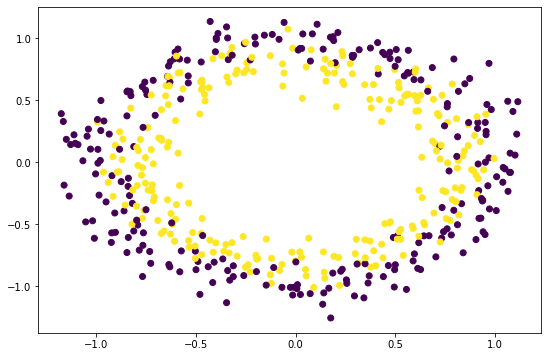

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles # sklearn.datasets에서는 다양한 데이터를 제공. 이 예시에서는 make_circles를 이용.
x, y = make_circles(n_samples=500, noise =0.1) # 500개의 점 생성.
plt.figure(figsize=(9,6))
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [2]:
x = torch.FloatTensor(x)

In [5]:
def l2distance(a,b): # 거리 함수 정의. L2 거리 함수 사용.
  return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0) # 각 점과 중심과의 거리 계산, 가장 거리가 가까운 점의 인덱스 반환

In [7]:
def kmeans(x, num_clusters=2, max_iteration = 5): # k-means 알고리즘에서는 클러스터의 수 정하는 것이 필수! 따라서 군집의 수를 모른다면 적절한 숫자 찾아야함.
# 여기서는 기본값을 num_clusters=2로 하였음. max_iteration은 중심이 업데이트되는 횟수를 의미.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  x = x.to(device)
  centroids = torch.rand(num_clusters, x.size(1)).to(device) # 초기 중심을 랜덤으로 할당. 중심 하나의 벡터 크기는 입력값의 피쳐 개수 x.size(1)와 같아야함.
  for update in range(max_iteration):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(num_clusters, -1) # 이때 입력값 하나가 각 중심까지의 거리를 구해야하므로, expand를 통해 입력값을 클러스터 개수만큼 복사, 확장.
      assign = l2distance(h, centroids) # 각 입력값마다 모든 중심과의 거리 계산, 가장 가까운 그룹으로 할당.
      y_assign.append(assign.item()) # 할당된 클러스터 정보 제공.

    y_assign = np.array(y_assign)
    if update !=max_iteration-1: # update 횟수 완료될 때까지 완성된 그룹들의 각 평균 계산, 중심 업데이트.
      for i in range(num_clusters):
        idx = np.where(y_assign==i)[0]
        centroids[i] = torch.mean(x[idx], dim=0)
      return y_assign, centroids

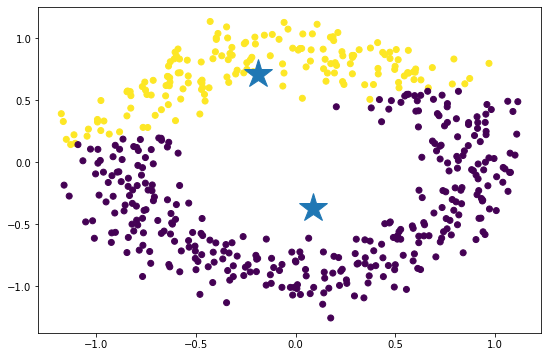

In [8]:
# 알고리즘 실행 & 그래프 그리기
# K-means 알고리즘은 sklearn에서 제공하는 from sklearn.cluster import KMeans가 가장 많이 사용됨.
# But, 파이토치를 통해 코드 작성 시 추후에 GPU 연산 가능, requires_grad를 사용하여 다른 모델과 조합 시 역전파도 이용 가능. (파이토치를 위한 라이브러리도 존재)
# 이 클러스터링은 방금 전의 클러스터링과 다르게 군집함!
# 따라서 클러스터링은 클러스터링의 종류, 거리 함수 종류, 클러스터의 개수 등의 사항을 잘 따져야함!
y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0], x[:,1], c=y_pred)
plt.plot(centroids[:,0], centroids[:,1], '*', markersize=30)
plt.show()

####(3) 오토인코더

#####1. 스택 오토인코더

In [9]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST('/content/drive/MyDrive/deeplearning/data', download=True, train=True,
                                     transform=transforms.ToTensor()) # torchvision.datasets.MNIST를 통해 데이터 불러옴. transforms를 이용, 텐서 데이터로 변환.
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

In [14]:
# 모델 구축
# 기본 오토인코더 모델은 층을 여러개 쌓았기에 스택 오토인코더라고도 불림.
class Autoencoder(nn.Module): # 모델 클래스 정의
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential( # 인코더와
        nn.Linear(784,128), # MNIST 이미지의 크기는 1X28X28임. => nn.Linear에 넣어주기 위해 사진을 일렬로 편 후, 인코더 부분에 크기가 784(28X28)인 벡터 하나가 들어옴.
        nn.ReLU(), # 층을 자유롭게 여러개 쌓아 노드를 10개 까지 줄임. 즉, 잠재 변수의 크기가 10으로 정의됨.
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.ReLU())
    self.decoder = nn.Sequential( # 디코더를 각각 nn.Sequential로 정리
        nn.Linear(10,32), # 크기가 줄어든 잠재 변수 벡터를 디코더에 넣어 다시 크기를 늘려줌.
        nn.ReLU(),
        nn.Linear(32,128),
        nn.ReLU(),
        nn.Linear(128, 28*28), # 마지막은 같은 크기의 이미지가 나와야함. => 28*28로 입력.
        nn.Sigmoid()) # MNIST 이미지의 픽셀값은 0 이상 1이하 => Sigmoid 함수의 성질을 이용해 범위를 정하여 수렴을 빨리 하게 할 수 있다.
    
  def forward(self,x): # forward에서는 encoder, decoder를 차례로 연산할 수 있도록 코드 작성.
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [15]:
# 모델, 손실 함수, 최적화 기법 정의
# 우리의 목적은 입력 이미지와 유사한 출력 이미지를 얻는 것. => 입력 이미지 & 출력 이미지의 L2 거리를 계산하는 MSE 손실 함수 사용, 최적화 방법 Adam 사용.
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
for epoch in range(51):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs.view(-1, 28*28)) # 현재 오토인코더의 층은 합성곱 층 X, 일렬 노드로 구성된 nn.Linear임. => 이미지를 일렬로 펴서 넣어주기 위해 inputs.view(-1, 28*28))를 입력값으로 이용.
    outputs = outputs.view(-1,1,28,28) # 벡터 형태로 나온 출력값을 다시 정사각형 이미지로 변환하기 위해, outputs.view(-1,1,28,28)를 작성.    
    loss = criterion(inputs, outputs)
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss: %.3f'%(epoch+1, cost))

[1] loss: 0.083
[2] loss: 0.059
[3] loss: 0.051
[4] loss: 0.043
[5] loss: 0.038
[6] loss: 0.036
[7] loss: 0.034
[8] loss: 0.033
[9] loss: 0.031
[10] loss: 0.030
[11] loss: 0.029
[12] loss: 0.029
[13] loss: 0.028
[14] loss: 0.028
[15] loss: 0.027
[16] loss: 0.027
[17] loss: 0.027
[18] loss: 0.027
[19] loss: 0.026
[20] loss: 0.026
[21] loss: 0.026
[22] loss: 0.026
[23] loss: 0.026
[24] loss: 0.026
[25] loss: 0.025
[26] loss: 0.025
[27] loss: 0.025
[28] loss: 0.025
[29] loss: 0.025
[30] loss: 0.025
[31] loss: 0.025
[32] loss: 0.025
[33] loss: 0.025
[34] loss: 0.024
[35] loss: 0.024
[36] loss: 0.024
[37] loss: 0.024
[38] loss: 0.024
[39] loss: 0.024
[40] loss: 0.024
[41] loss: 0.024
[42] loss: 0.024
[43] loss: 0.024
[44] loss: 0.024
[45] loss: 0.024
[46] loss: 0.024
[47] loss: 0.023
[48] loss: 0.023
[49] loss: 0.023
[50] loss: 0.023
[51] loss: 0.023


#####2. 디노이징 오토인코더

In [17]:
for epoch in range(101):
  running_loss = 0.0
  for data in trainloader:

    inputs = data[0].to(device)
    optimizer.zero_grad()
    dirty_inputs = inputs + torch.normal(0, 0.5, size = inputs.size()).to(device) # 해당 코드는 스택 오토 인코더와 동일, but 입력 이미지에 가우시안 노이즈를 주입한다는 차이점.
    outputs = model(dirty_inputs.view(-1, 28*28)) # 노이즈 텐서의 사이즈=이미지 사이즈여야 하므로 size = inputs.size()를 입력, 평균과 표준편차는 임의로 0, 0.5를 넣음.
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs, outputs)


    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss: %.3f' %(epoch + 1, cost))

[1] loss: 0.031
[2] loss: 0.030
[3] loss: 0.029
[4] loss: 0.029
[5] loss: 0.028
[6] loss: 0.028
[7] loss: 0.028
[8] loss: 0.028
[9] loss: 0.028
[10] loss: 0.028
[11] loss: 0.028
[12] loss: 0.027
[13] loss: 0.027
[14] loss: 0.027
[15] loss: 0.027
[16] loss: 0.027
[17] loss: 0.027
[18] loss: 0.027
[19] loss: 0.027
[20] loss: 0.027
[21] loss: 0.027
[22] loss: 0.027
[23] loss: 0.027
[24] loss: 0.027
[25] loss: 0.027
[26] loss: 0.026
[27] loss: 0.026
[28] loss: 0.026
[29] loss: 0.026
[30] loss: 0.026
[31] loss: 0.026
[32] loss: 0.026
[33] loss: 0.026
[34] loss: 0.026
[35] loss: 0.026
[36] loss: 0.026
[37] loss: 0.026
[38] loss: 0.026
[39] loss: 0.026
[40] loss: 0.026
[41] loss: 0.026
[42] loss: 0.026
[43] loss: 0.026
[44] loss: 0.026
[45] loss: 0.026
[46] loss: 0.026
[47] loss: 0.026
[48] loss: 0.026
[49] loss: 0.026
[50] loss: 0.026
[51] loss: 0.026
[52] loss: 0.025
[53] loss: 0.025
[54] loss: 0.025
[55] loss: 0.025
[56] loss: 0.025
[57] loss: 0.025
[58] loss: 0.025
[59] loss: 0.025
[60] l

#####3. 합성곱 오토인코더

In [19]:
# 피쳐맵을 벡터화
class Flatten(torch.nn.Module):
  def forward(self,x):
    batch_size = x.shape[0] # 인코더를 거친 피쳐맵의 크기 = (배치 사이즈, 채널 수, 이미지 너비, 이미지 높이) => 배치 사이즈 = 현재 이미지의 개수, 벡터가 배치 사이즈 만큼 존재해야함.
    return x.view(batch_size, -1) # 즉, x.view(batch_size, -1)를 이용, 각 피쳐 데이터를 일렬로 변환.

In [20]:
# 벡터를 사각형 피쳐맵으로 변환
class Deflatten(nn.Module):
  def __init__(self,k):
    super(Deflatten, self).__init__()
    self.k = k

  def forward(self,x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5) # 잠재 변수 h의 크기 = (배치사이즈, 채널 수*이미지 너비*이미지 높이) => 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이, 너비=높이라면 채널 수*이미지 너비**2.
    # 이미지 한 변의 길이 = (벡터 사이즈//채널 수)**.5
    return x.view(s[0], self.k, feature_size, feature_size) # 피쳐맵의 크기를 (배치사이즈, 채널 수, 이미지 너비, 이미지 높이) = (s[0], self.k, feature_size, feature_size)로 반환.

In [24]:
# 모델 구축
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2), nn.ReLU(), # 합성곱 층 생성
        nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride = 1), nn.ReLU(),
        Flatten(), nn.Linear(1024, 10), nn.ReLU()) # 합성곱 층으로부터 나온 피쳐맵을 일렬로 폄. 피쳐맵으로 만든 벡터를 은닉층 1개를 거쳐 크기가 10인 잠재 변수로 만듦.
    
    self.decoder = nn.Sequential(
        nn.Linear(10,1024), nn.ReLU(), # 잠재 변수를 은닉층 하나를 통해 다시 크기가 1024인 벡터로 만듦.
        Deflatten(4*k), # 사각형 형태의 피쳐맵으로 변환. nn.Conv2d는 일반적으로 입력 사이즈 < 출력 사이즈임.
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(), # 크기가 작은 입력 값 => 크기가 큰 입력 값으로 만들기 위해 nn.Conv2d 대신 nn.ConvTranspose2d 사용.
        # nn.ConvTranspose2d는 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분, 그 값을 입력 벡터와 곱해 출력 벡터 산출, 그 결과 벡터를 행렬 형태로 변환하는 연산.
        # 사용방법은 nn.Conv2d와 동일(nn.ConvTranspose2d(입력 채널 수, 출력 채널 수, 필터 크기, stride)), 크기는 일반적인 정사각형 이미지와 필터 사용 시 다음 식에 의해 피쳐맵 크기 산출 가능.
        # (출력값의 크기) = (입력값의 크기-1)X(보폭)-2X(패딩)+(필터의 크기)+(출력값 패딩)
        nn.ConvTranspose2d(2*k, k, 3, stride =2), nn.ReLU(),
        nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid()) # output_padding은 크기를 맞춰주기 위해 전치 합성곱 연산 후 패딩을 씌워주는 역할.
    
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [25]:
# 모델, 손실 함수, 최적화 기법 정의
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# 학습하기
# 오토인코더와 학습 과정은 동일. But, 이미지를 그대로 받아 학습하므로 별도의 크기변환 필요 X. => 합성곱 오토인코더는 이미지 처리에서는 기본 신경망을 이용하는 오토인코더보다 성능 좋음.
for epoch in range(51):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(inputs,outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  cost = running_loss / len(trainloader)
  if epoch % 10 ==0:
    print('[%d] loss: %.3f' %(epoch +1, cost))

[1] loss: 0.057
[11] loss: 0.022
[21] loss: 0.020
[31] loss: 0.020
[41] loss: 0.019
[51] loss: 0.019


#####4. 생성적 적대 신경망